# Определение токсичных комментариев

### Вариант решения с использованием BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 

То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель:**
- создать модель определения токсичныхъ комментариев

**Метрика:**
- метрика для оценки качества модели F1

**Точность:**
- F1 лучшей модели должено быть не ниже **0.75**

В нашем распоряжении набор данных с разметкой о токсичности правок.

## Импорт библиотек

In [ ]:
!pip install transformers

In [ ]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np

import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
import lightgbm


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import re
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [4]:
sns.set_theme(style="whitegrid")

In [5]:
RANDOM = 12345
scaler = StandardScaler()

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
torch.cuda.is_available()

True

In [9]:
torch.cuda.device_count()

1

In [10]:
device = torch.device('cuda:0')

In [11]:
# Confusion Matrix Plot

def plot_cm(target, predictions, model):
    cm = confusion_matrix(target, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=model.classes_)
    disp.plot()
    plt.show()

## Загрузка и обработка текста

In [ ]:
import os

pth1 = '../datasets/toxic_comments.csv'
pth2 = '/content/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, error_bad_lines=False)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, error_bad_lines=False)
else:
    print('Проверьте пути к датасету')

In [13]:
df['toxic'].unique()

array(['0', '1', nan, ' removed also by ALR. Why.',
       ' and possibly edit the article. Thank you for your time.99.41.251.5 (talk)”',
       ' but you judge.', ' and on pages like votes for deletion',
       ' Sime Darby is poised with the potential for more in the future"""". This statement is also somewhat judgemental.',
       ' anything yet?',
       " Wikipedia's most-viewed board has declared a specific living person has terminal cancer.",
       ',0\nquestion', ' re:Open access publishing',
       ',0\nSockpuppet Investigation of User:Anyones Else For Nutley ',
       ' you are absolutely correct.  Keep up the good work.  ',
       " I suspect there's a great deal of history that I'm woefully unaware of.  Thank you. —   \xa0?\xa0 ",
       ' though a minority opinion."""" - Enough evidence to include parent systems in Infobox.',
       ' you will be blocked from editing.   (T) ',
       ' Time Magazine Article & The New Statesmen. ',
       ' in that it infers that Noel Stan

In [14]:
df.isna().sum()

text       0
toxic    131
dtype: int64

In [15]:
df = df.dropna().reset_index(drop=True)

In [16]:
df['toxic'].value_counts()

0                                                                                                                                                                                          143106
1                                                                                                                                                                                           16186
,0\n"                                                                                                                                                                                           1
 """"Bosnia and Herzegovina [...] will try to keep a neutral position due to a complex domestic political scene and numerous unsolved political and economic issues in the country.""""         1
 I do play Go (though not so much for a while)                                                                                                                                                  1
 the Sozin's Comet Book (which

В таргет затесались комментарии - избавимся от них

In [17]:
drop_index = df.query('toxic != "0" and toxic != "1"').index

In [18]:
df_comm = df.drop(index=drop_index).reset_index(drop=True)

In [19]:
df_comm

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [20]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

Выберем сэмплы

In [21]:
df_comm = df_comm.sample(1000, random_state=RANDOM).reset_index(drop=True)

In [22]:
df_comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   toxic   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [23]:
X, y = df_comm.text, df_comm.toxic

y.unique()

array(['0', '1'], dtype=object)

In [24]:
y = y.astype(int)

y.unique()

array([0, 1])

In [25]:
X

0      Expert Categorizers  \n\nWhy is there no menti...
1                         "\n\n Noise \n\nfart*  talk. "
2      An indefinite block is appropriate, even for a...
3      I don't understand why we have a screenshot of...
4      Hello! Some of the people, places or things yo...
                             ...                        
995    "\n Your submission at Articles for creation \...
996    So they didn't see anything, as there isn't an...
997    RE:\nHave a look:\n all listed pages \nFalse g...
998    "\n\n Dear Helladios can you stop deleting my ...
999    PS. Saxifrage after you are done gobbling on t...
Name: text, Length: 1000, dtype: object

In [26]:
X = X.apply(lambda x: clear_text(x))

In [27]:
X

0      Expert Categorizers Why is there no mention of...
1                                        Noise fart talk
2      An indefinite block is appropriate even for a ...
3      I don t understand why we have a screenshot of...
4      Hello Some of the people places or things you ...
                             ...                        
995    Your submission at Articles for creation NOVA ...
996    So they didn t see anything as there isn t any...
997    RE Have a look all listed pages False garden m...
998    Dear Helladios can you stop deleting my input ...
999    PS Saxifrage after you are done gobbling on th...
Name: text, Length: 1000, dtype: object

При использовании BERT ручная обработка комментариев не понадобится.

Используем встроенный токенайзер

In [28]:
# Задаем максимально возможную длину, тк при поиске результат был 2145)
max_length = 512

tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenized = X.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))


        
padded = np.array([i + [0]*(max_length - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
tokenized

0      [101, 6739, 4937, 20265, 25709, 2869, 2339, 20...
1                     [101, 5005, 2521, 2102, 2831, 102]
2      [101, 2019, 25617, 3796, 2003, 6413, 2130, 200...
3      [101, 1045, 2123, 1056, 3305, 2339, 2057, 2031...
4      [101, 7592, 2070, 1997, 1996, 2111, 3182, 2030...
                             ...                        
995    [101, 2115, 12339, 2012, 4790, 2005, 4325, 684...
996    [101, 2061, 2027, 2134, 1056, 2156, 2505, 2004...
997    [101, 2128, 2031, 1037, 2298, 2035, 3205, 5530...
998    [101, 6203, 3109, 17190, 2891, 2064, 2017, 264...
999    [101, 8827, 19656, 10128, 24449, 2044, 2017, 2...
Name: text, Length: 1000, dtype: object

In [30]:
model = transformers.AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [31]:
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
features = np.concatenate(embeddings)
target = y

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=RANDOM, shuffle=True)



## Logistic Regression

In [33]:
lr_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

In [34]:
lr_f1 = f1_score(y_test, lr_predictions, average='binary')

In [35]:
lr_f1

0.6956521739130435

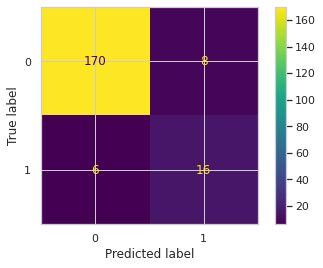

In [36]:
plot_cm(y_test, lr_predictions, lr_model)

### Upsampling

## Logistic Regression с ресемплированным датасетом RandomOverSample

In [37]:
ros = RandomOverSampler(random_state=RANDOM)

X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [38]:
lr_ros_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_ros_model.fit(X_ros, y_ros)

lr_ros_predictions = lr_ros_model.predict(X_test)

In [39]:
lr_ros_f1 = f1_score(y_test, lr_ros_predictions, average='binary')

In [40]:
lr_ros_f1

0.68

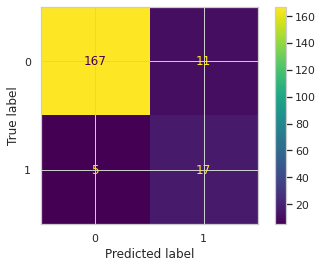

In [41]:
plot_cm(y_test, lr_ros_predictions, lr_ros_model)

## Logistic Regression с ресемплированным датасетом SMOTE

In [42]:
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

In [43]:
lr_smote_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_smote_model.fit(X_smote, y_smote)

lr_smote_predictions = lr_smote_model.predict(X_test)

In [44]:
lr_smote_f1 = f1_score(y_test, lr_smote_predictions, average='binary')

In [45]:
lr_smote_f1

0.6521739130434783

## Logistic Regression с ресемплированным датасетом ADASYN

In [46]:
X_ada, y_ada = ADASYN().fit_resample(X_train, y_train)

In [47]:
lr_ada_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_ada_model.fit(X_ada, y_ada)

lr_ada_predictions = lr_ada_model.predict(X_test)

In [48]:
lr_ada_f1 = f1_score(y_test, lr_ada_predictions, average='binary')

In [49]:
lr_ada_f1

0.68

SMOTE показал лучший результат. Попробую разные вариации, которые есть.

In [50]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTEN

In [51]:
X_bls, y_bls = BorderlineSMOTE().fit_resample(X_train, y_train)

In [52]:
lr_bls_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_bls_model.fit(X_bls, y_bls)

lr_bls_predictions = lr_bls_model.predict(X_test)

lr_bls_f1 = f1_score(y_test, lr_bls_predictions, average='binary')

lr_bls_f1

0.6666666666666666

In [53]:
X_smt, y_smt = SMOTEN(random_state=RANDOM).fit_resample(X_train, y_train)

In [54]:
lr_smt_model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

lr_smt_model.fit(X_smt, y_smt)

lr_smt_predictions = lr_smt_model.predict(X_test)

lr_smt_f1 = f1_score(y_test, lr_smt_predictions, average='binary')

lr_smt_f1

0.6511627906976744

In [ ]:
!pip install optuna

In [56]:
import optuna

param_distrs = {
                'C':optuna.distributions.LogUniformDistribution(0.1, 20),
                'max_iter':optuna.distributions.IntUniformDistribution(800, 1200, 100)
                }

opt_search = optuna.integration.OptunaSearchCV(lr_smote_model, param_distrs, cv = 4,
                                                n_trials=5, scoring='f1', timeout=500)

In [57]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

Тк upsampling SMOTE показал лучшие результаты - возьмем данные для длальнейштх экспериментов

In [58]:
opt_search.fit(X_smote, y_smote)

[I 2022-11-23 21:47:15,895] A new study created in memory with name: no-name-a14b80cb-fc6d-47f3-a948-1cc657867d99
[I 2022-11-23 21:50:23,549] Trial 0 finished with value: 0.9654392332885863 and parameters: {'C': 0.389631861883641, 'max_iter': 800}. Best is trial 0 with value: 0.9654392332885863.
[I 2022-11-23 21:54:16,288] Trial 1 finished with value: 0.9667608061087336 and parameters: {'C': 1.5625725198255107, 'max_iter': 1200}. Best is trial 1 with value: 0.9667608061087336.
[I 2022-11-23 21:57:18,506] Trial 2 finished with value: 0.9661159346482809 and parameters: {'C': 4.221775721069465, 'max_iter': 800}. Best is trial 1 with value: 0.9667608061087336.


OptunaSearchCV(cv=4,
               estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                            random_state=12345),
               n_trials=5,
               param_distributions={'C': FloatDistribution(high=20.0, log=True, low=0.1, step=None),
                                    'max_iter': IntDistribution(high=1200, log=False, low=800, step=100)},
               scoring='f1', timeout=500)

In [59]:
opt_search.best_params_

{'C': 1.5625725198255107, 'max_iter': 1200}

In [60]:
opt_search.best_score_

0.9667608061087336

In [61]:
opt_search.best_estimator_

LogisticRegression(C=1.5625725198255107, class_weight='balanced', max_iter=1200,
                   n_jobs=-1, random_state=12345)

In [62]:
opt_lr = opt_search.best_estimator_

opt_lr_predictions = opt_lr.predict(X_test)

opt_lr_f1 = f1_score(y_test, opt_lr_predictions, average='binary')

print(opt_lr_f1)

0.6382978723404256


Прошлый результат был 0.6. С Апсемплом стал: 0.62. Не лучший результат

Ищем дальше


## Random Forest

In [63]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

rf_model.fit(X_smote, y_smote)

rf_predictions = rf_model.predict(X_test)

In [64]:
rf_f1 = f1_score(y_test, rf_predictions, average='binary')

rf_f1

0.6842105263157896

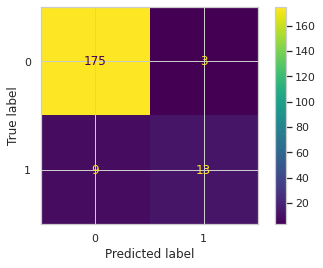

In [65]:
plot_cm(y_test, rf_predictions, rf_model)

## Cat Boost

In [66]:
cb_model = CatBoostClassifier(random_state=RANDOM, verbose=20)

param_distrs = {
                'learning_rate':optuna.distributions.LogUniformDistribution(0.01, 0.1),
                'max_depth':optuna.distributions.IntUniformDistribution(3, 5),
                'n_estimators':optuna.distributions.IntUniformDistribution(10, 50, 20)
                }

opt_search_CB = optuna.integration.OptunaSearchCV(cb_model, param_distrs, cv = 4,
                                                n_trials=3, scoring='f1', timeout=500)

opt_search_CB.fit(X_smote, y_smote)

print(f'Лучший результат: {opt_search_CB.best_score_}')
print(f'Лучшие параметры: {opt_search_CB.best_params_}')

[I 2022-11-23 21:59:03,045] A new study created in memory with name: no-name-a7dbd906-a3ef-4fd0-8144-2c9cff93eca3


0:	learn: 0.6581159	total: 3.61s	remaining: 2m 56s
20:	learn: 0.2659828	total: 59.4s	remaining: 1m 22s
40:	learn: 0.1688448	total: 1m 53s	remaining: 25s
49:	learn: 0.1427594	total: 2m 18s	remaining: 0us
0:	learn: 0.6544184	total: 3.28s	remaining: 2m 40s
20:	learn: 0.2911299	total: 57.5s	remaining: 1m 19s
40:	learn: 0.1839503	total: 1m 50s	remaining: 24.3s
49:	learn: 0.1551693	total: 2m 15s	remaining: 0us
0:	learn: 0.6522714	total: 3.16s	remaining: 2m 34s
20:	learn: 0.2806180	total: 57.6s	remaining: 1m 19s
40:	learn: 0.1791892	total: 1m 51s	remaining: 24.6s
49:	learn: 0.1479271	total: 2m 16s	remaining: 0us
0:	learn: 0.6573465	total: 3.21s	remaining: 2m 37s
20:	learn: 0.2891569	total: 56.2s	remaining: 1m 17s
40:	learn: 0.1867373	total: 1m 50s	remaining: 24.3s
49:	learn: 0.1588648	total: 2m 15s	remaining: 0us


[I 2022-11-23 22:09:01,544] Trial 0 finished with value: 0.9534116603299445 and parameters: {'learning_rate': 0.04480132905109042, 'max_depth': 4, 'n_estimators': 50}. Best is trial 0 with value: 0.9534116603299445.


0:	learn: 0.6528052	total: 3.22s	remaining: 2m 37s
20:	learn: 0.2848206	total: 57.8s	remaining: 1m 19s
40:	learn: 0.1809114	total: 1m 52s	remaining: 24.6s
49:	learn: 0.1518748	total: 2m 16s	remaining: 0us
Лучший результат: 0.9534116603299445
Лучшие параметры: {'learning_rate': 0.04480132905109042, 'max_depth': 4, 'n_estimators': 50}


In [67]:
cb_model = CatBoostClassifier(**opt_search_CB.best_params_)

cb_model.fit(X_smote, y_smote, plot=False, verbose=None)

cb_predictions = cb_model.predict(X_test)

0:	learn: 0.6508868	total: 3.17s	remaining: 2m 35s
1:	learn: 0.6145661	total: 5.74s	remaining: 2m 17s
2:	learn: 0.5810912	total: 8.35s	remaining: 2m 10s
3:	learn: 0.5510196	total: 10.9s	remaining: 2m 5s
4:	learn: 0.5162676	total: 13.5s	remaining: 2m 1s
5:	learn: 0.4901490	total: 16.1s	remaining: 1m 58s
6:	learn: 0.4672853	total: 18.8s	remaining: 1m 55s
7:	learn: 0.4418079	total: 22.9s	remaining: 2m
8:	learn: 0.4237982	total: 25.5s	remaining: 1m 56s
9:	learn: 0.4056264	total: 28.1s	remaining: 1m 52s
10:	learn: 0.3912148	total: 30.7s	remaining: 1m 48s
11:	learn: 0.3781523	total: 33.3s	remaining: 1m 45s
12:	learn: 0.3631274	total: 35.9s	remaining: 1m 42s
13:	learn: 0.3486755	total: 38.5s	remaining: 1m 38s
14:	learn: 0.3351350	total: 41s	remaining: 1m 35s
15:	learn: 0.3265057	total: 43.6s	remaining: 1m 32s
16:	learn: 0.3165255	total: 46.2s	remaining: 1m 29s
17:	learn: 0.3069174	total: 48.8s	remaining: 1m 26s
18:	learn: 0.2979672	total: 51.4s	remaining: 1m 23s
19:	learn: 0.2892517	total: 53

In [68]:
cb_f1 = f1_score(y_test, cb_predictions, average='binary')

cb_f1

0.6666666666666667

In [71]:
from lightgbm import LGBMClassifier as lgb

In [72]:
params = {
    'learning_rate': 0.1,
    "num_leaves": 50,  
    "max_depth": 5,
    "max_bin" : 100,
    "num_iterations": 2000,
    "metric" : 'auc'
}
lgb_model = lgb(**params, n_jobs=-1)
lgb_model.fit(X_smote, y_smote, eval_set=(X_test, y_test), verbose=100)

lgb_preds = lgb_model.predict(X_test)

lgb_f1_res = f1_score(y_test, lgb_preds)

[100]	valid_0's auc: 0.938968
[200]	valid_0's auc: 0.942543
[300]	valid_0's auc: 0.945352
[400]	valid_0's auc: 0.945097
[500]	valid_0's auc: 0.945097
[600]	valid_0's auc: 0.945097
[700]	valid_0's auc: 0.945097
[800]	valid_0's auc: 0.945097
[900]	valid_0's auc: 0.945097
[1000]	valid_0's auc: 0.945097
[1100]	valid_0's auc: 0.945097
[1200]	valid_0's auc: 0.945097
[1300]	valid_0's auc: 0.945097
[1400]	valid_0's auc: 0.945097
[1500]	valid_0's auc: 0.945097
[1600]	valid_0's auc: 0.945097
[1700]	valid_0's auc: 0.945097
[1800]	valid_0's auc: 0.945097
[1900]	valid_0's auc: 0.945097
[2000]	valid_0's auc: 0.945097


In [73]:
lgb_f1_res

0.6363636363636364

## Вывод

In [74]:
best_model = {
    'CatBoost' : round(cb_f1, 4),
    'Random Forest' : round(rf_f1, 4),
    'LogReg' : round(lr_f1, 4),
    'LogReg_opt' : round(opt_lr_f1, 4),
    'LGB' : round(lgb_f1_res, 4)
}
index = ['f1_score']

best_model = pd.DataFrame(best_model, index=index)

In [75]:
best_model.T.sort_values('f1_score', ascending=False)

,f1_score
LogReg,0.6957
Random Forest,0.6842
CatBoost,0.6667
LogReg_opt,0.6383
LGB,0.6364


# Вывод

Данные обработаны и осмотрены

Проведена токенизация и векторизация текста

Порог по метрике модель не прошла.

Для данной задачи BERT не совсем подходит в моем случае:
- нет вычислительных мощностей, для работы с большим количеством текста
- следовательно слишком мало данных для обучения

Вариант с TF-IDF показал лучшие результаты на представленных данных.